In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = ['year','num']
data = pd.read_csv('data/lynx.csv', index_col='year', 
                    parse_dates=True,names = names, header = 0)
data1 = pd.read_csv('data/lynx.csv', index_col='year', 
                    parse_dates=True,names = names, header = 0)
# data.head()

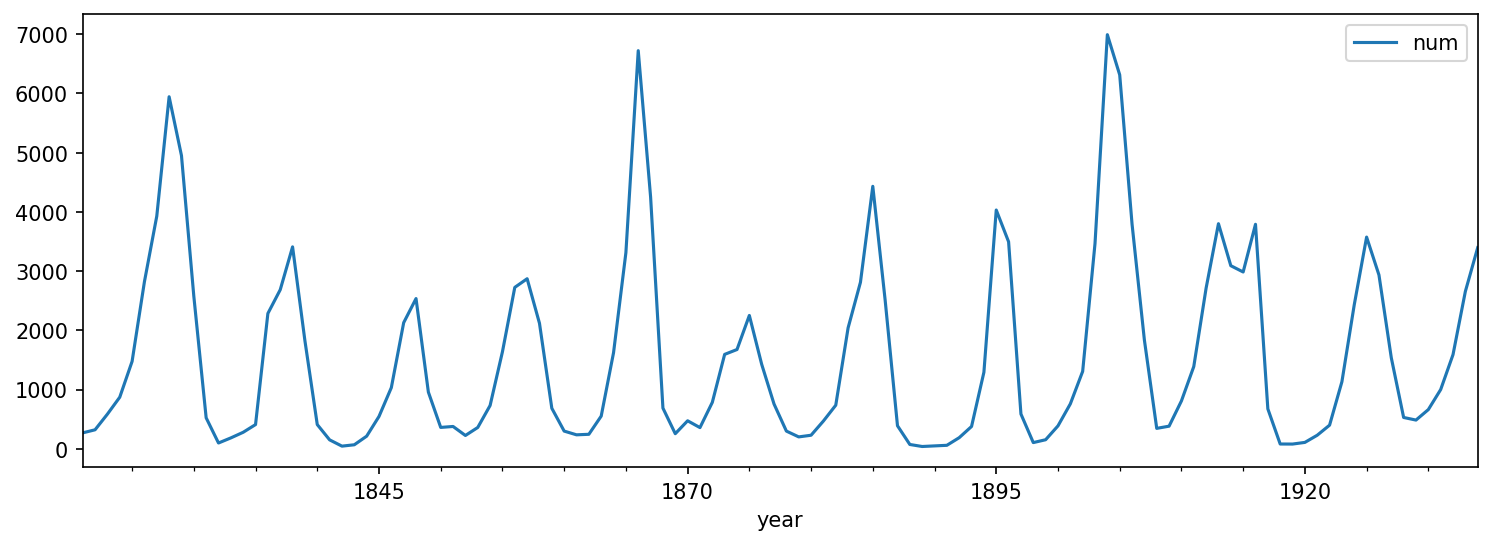

In [3]:
plt.figure(figsize=(12, 4), dpi=150)
data['num'].plot(legend=True)
plt.show()

In [4]:
def approximation(data: np.array, params: np.array) -> int:
    val = pd.DataFrame({'num' : data})
    for i in range(len(params) - 1):
        val['y' + str(i + 1)] = val['num'].shift(i + 1)
    phi = params[1:]
    phi.shape = (1, len(phi))
    val = val.dropna()
    return (phi @ val.iloc[:, 1:].T + params[0]).values[0]

In [5]:
def mean_square_error_for_autoregressive(data: np.array, params: np.array) -> int:
    return ( (data[len(params) - 1:] - approximation(data, params))**2 ).mean()

In [6]:
def autoregressive_parameter(data: np.array, number_autoregressive_parameters: int) -> np.array:
    mse = lambda x: mean_square_error_for_autoregressive(data, x)
    df = minimize(mse, np.zeros(number_autoregressive_parameters + 1))
    
    return df.x

In [7]:
def error_approximation(data: np.array, params_moving_average: np.array, autoregressive_params: np.array) ->int:
    forecast = approximation(data, autoregressive_params)
    
    mistake = forecast - data[len(autoregressive_params) - 1:]
    
    mistake = pd.DataFrame({'num': mistake})
    
    for i in range(len(params_moving_average) - 1):
        mistake['e' + str(i + 1)] = mistake['num'].shift(i + 1)
    mistake = mistake.dropna()
    
    theta = params_moving_average[1:]
    theta.shape = (1, len(theta))
    
    return (theta @ mistake.iloc[:, 1:].T + params_moving_average[0]).values[0]

In [8]:
def mean_square_error_for_moving_average(data: np.array, mistake: np.array, params: np.array, autoregressive_params: np.array) -> int:
    return ( (mistake[len(params) - 1:] - error_approximation(data, params, autoregressive_params))**2 ).mean()

In [9]:
def moving_average_parameter(data: np.array, mistake: np.array, number_moving_average: int, autoregressive_params: np.array) -> np.array:    
    mse = lambda x: mean_square_error_for_moving_average(data, mistake, x, autoregressive_params)
    
    df = minimize(mse, np.zeros(number_moving_average + 1))
    
    return df.x

In [83]:
autoregressive_params = autoregressive_parameter(data.values.T[0], 2)
forecast = approximation(data.values.T[0], autoregressive_params)
mistake = forecast - data.values.T[0][len(autoregressive_params) - 1:]
autoregressive_params

array([ 7.10111950e+02,  1.15242145e+00, -6.06230089e-01])

In [84]:
mean_square_error_for_moving_average(data.values.T[0], mistake, np.array([1,2,3]), autoregressive_params)

11536364.856908351

In [85]:
moving_average_parameter(data.values.T[0], mistake, 2, autoregressive_params)

array([-4.08397971, -0.02090869, -0.14952143])

In [13]:
def arma(data: np.array, number_moving_average: int, number_autoregressive_params: int, h: int) -> np.array:
    
    autoregressive_params = autoregressive_parameter(data, number_autoregressive_params)
    forecast = approximation(data, autoregressive_params)
    mistake = forecast - data[number_autoregressive_params:]
    
    moving_average_params = moving_average_parameter(data, mistake, 2, autoregressive_params)
    
    e = error_approximation(data, moving_average_params, autoregressive_params)

    return forecast[2:] + e


#     end = min(len(data) - number_autoregressive_params, len(mistake) - number_moving_average)
#     f=[]
#     for i in range(0, end + h):
#         if i < end:
#             pred = autoregressive_params[0] + (autoregressive_params[1:] @ data[i: i + number_autoregressive_params]) + moving_average_params[0] + (moving_average_params[1:] @ mistake[i: i + number_moving_average])
    
#         f.append(pred)
    
#     return np.array(f)

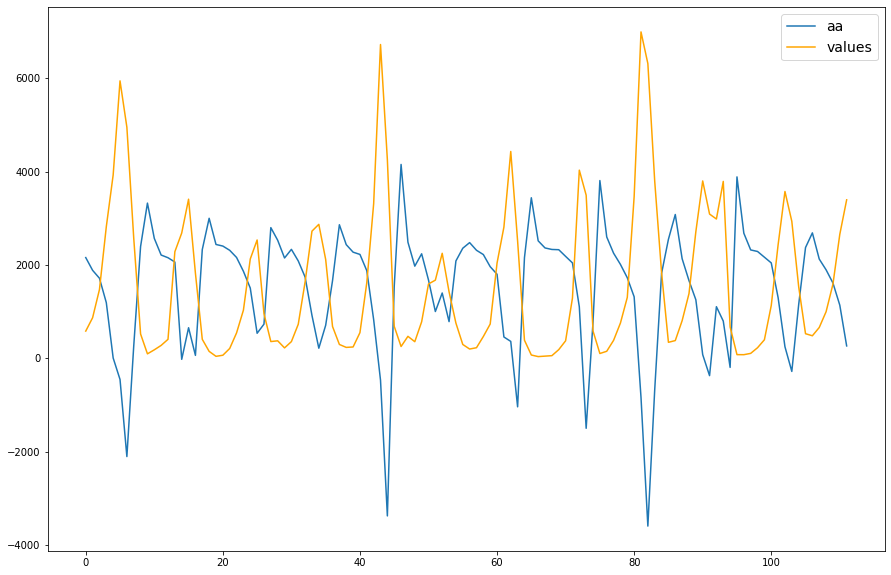

In [15]:
plt.figure(figsize=(15,10))
plt.plot(arma(data.values.T[0], 2, 0, 0), label = 'aa')
plt.plot(data.values.T[0][2:], label = 'values', color='orange')
plt.legend(fontsize = 14)
plt.show()

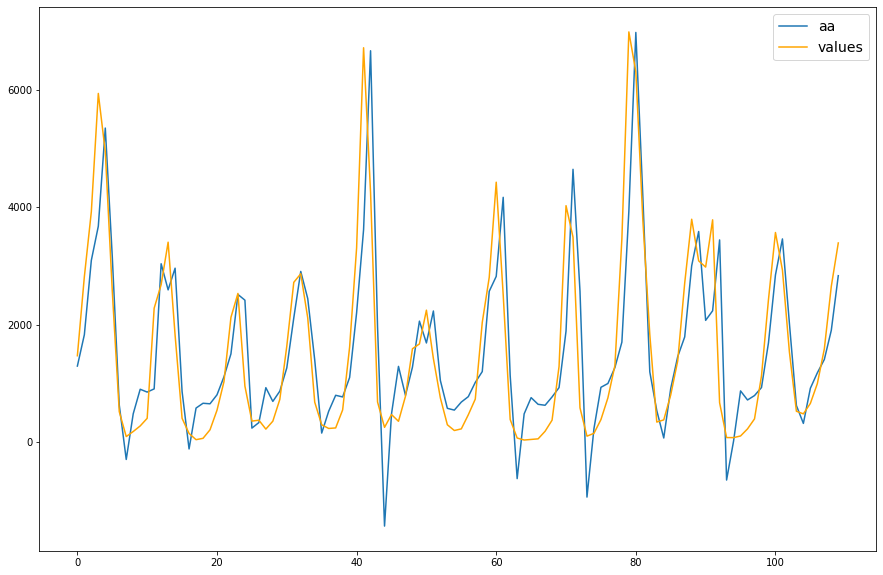

In [16]:
plt.figure(figsize=(15,10))
plt.plot(arma(data.values.T[0], 2, 2, 0), label = 'aa')
plt.plot(data.values.T[0][4:], label = 'values', color='orange')
plt.legend(fontsize = 14)
plt.show()

In [10]:
def incomplete_arma(values, params):
    values = np.array(values)
    params = np.array(params)
    forecast = []
    for i in range(0, len(values) - len(params) + 1):
        pred = params[0] + (params[1:] @ values[i: i + len(params) - 1])
        forecast.append(pred)
    return forecast

In [11]:
def mean_square_error_incomplete_arma(data, params):
    forecast = incomplete_arma(data, params)
    return (np.array((data[len(params) - 1:] - forecast))**2).mean()

In [12]:
def arma(values, params_moving_average, number_autoregressive_params, h):
    values = np.array(values)
    params_2 = params_moving_average
    
    mse = lambda x: mean_square_error_incomplete_arma(values, x)

    df = minimize(mse, np.zeros(number_autoregressive_params + 1))
    
    params_1 = df.x
    
    forecast = np.array(incomplete_arma(values, params_1))
    
    values = values[len(params_1) - 1 :]
    
    mistake = values - forecast
    
    forecast2 = []
    for i in range(0, len(mistake) - 1 + h):
        if i < len(mistake) - max(len(params_1), len(params_2)):
            pred = params_1[0] + (params_1[1:] @ values[i: i + len(params_1) - 1]) + params_2[0] + (params_2[1:] @ mistake[i: i + len(params_moving_average) - 1])
        else:
            pred = params_1[0] + (params_1[1:] @ forecast2[-len(params_1) + 1:]) + params_2[0] + (params_2[1:] @ mistake[-len(params_2) + 1:])
        forecast2.append(pred)
        
    return forecast2

In [260]:
def mean_square_error_arma(data, params_moving_average, number_autoregressive_params):
    forecast = arma(data, params_moving_average, number_autoregressive_params, 0)
    lost_values = max(len(params_moving_average), number_autoregressive_params + 1)
    return ((np.array(forecast) - data[lost_values:])**2).mean()

In [261]:
def curtained_arma(values, number_moving_average, number_autoregressive_params, h):
    
    mse = lambda x: mean_square_error_arma(data, x, 2)
    df2 = minimize(mse, np.zeros(number_moving_average + 1))
    
    params_2 = df2.x
    
    return arma(values, params_2, number_autoregressive_params, h)

In [262]:
forecast = curtained_arma(data, 2, 2, 0)

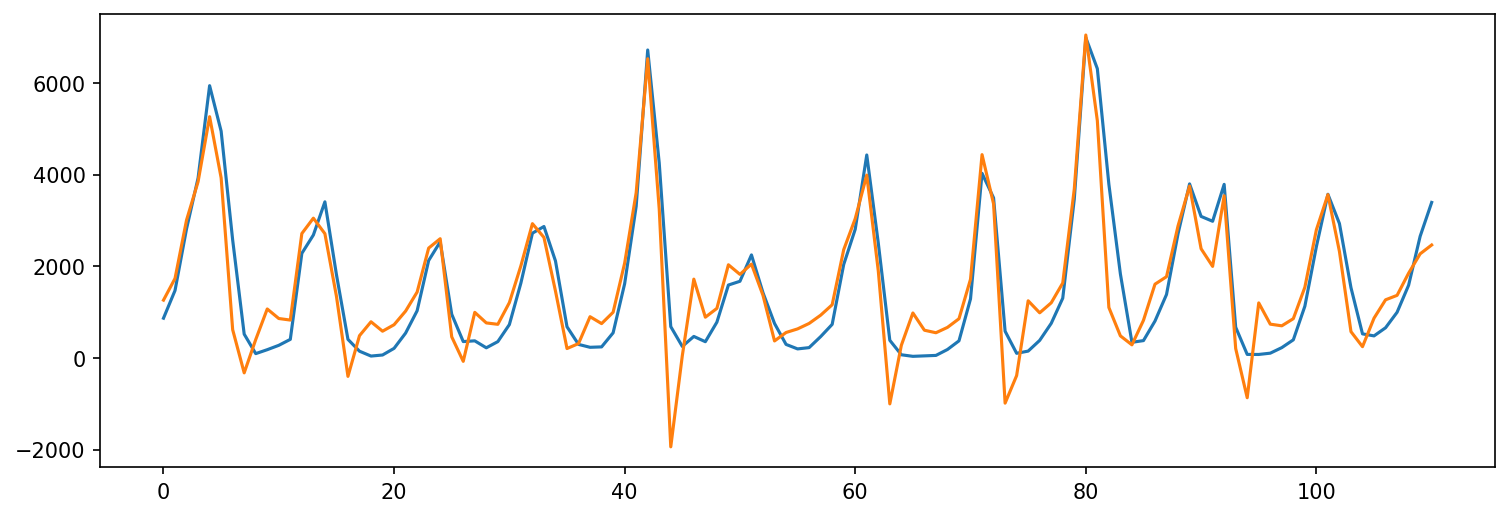

In [263]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(data[3:].values)
plt.plot(forecast)
plt.show()